## Cross-Validation of Machine Learning Models

This notebook runs cross-validation tests to determine the effectiveness of a variety of machine learning models on our data.

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss, f1_score
import time

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

import warnings

First, let's import our data and get rid of instances with a current income of $1,000 or less, for which income shocks are ill-defined.

In [3]:
cohort_79 = pd.read_csv('data/cohort79_Jun8.csv')
cohort_97 = pd.read_csv('data/cohort97_Jun8.csv')

merged_data = pd.concat([cohort_79, cohort_97], sort=False)
merged_data.drop(merged_data[merged_data["adjusted_income"] <= 1000].index, inplace=True)
merged_data.fillna(0, inplace=True)

predictors = list(merged_data.columns)
vars_to_drop = ["case_id", "urban_or_rural", "family_size", "sample_id", "year", "shock", "region", "highest_grade", "industry", "occupation", "Unnamed: 0",'marital_status', 'race', "region_1", "region_2", "region_3", "region_4", "work_kind_limited", "work_amount_limited"]
for var in vars_to_drop:
    predictors.remove(var)
    
X = merged_data[predictors]
y = np.ravel(merged_data["shock"])

Then, define a function to cross-validate each model.

In [35]:
def score_model(X, y, estimator, n_folds, scale=False, **kwargs):
    
    kf = KFold(n_splits = n_folds)
    f1_scores = []
    brier_scores = []
    log_loss_scores = []
    start = time.time()
    
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if scale:
            # The standard scaler will raise a warning about variable types. To suppress those for the moment...    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)

        estimator.fit(X_train, y_train, **kwargs)  

        expected  = y_test
        predicted = estimator.predict(X_test)
        predicted_proba = estimator.predict_proba(X_test)[:,1]
        
        f1_scores.append(f1_score(expected, predicted, average="weighted"))
        brier_scores.append(brier_score_loss(expected, predicted_proba))
        log_loss_scores.append(log_loss(expected, predicted_proba))
    
    end = time.time()

    print("Model: {}".format(estimator.__class__.__name__))
    print("F1 score (higher is better): {:.03f}".format(np.mean(f1_scores)))
    print("Brier score loss (lower is better): {:.03f}".format(np.mean(brier_scores)))
    print("Log loss (lower is better): {:.03f}".format(np.mean(log_loss_scores)))
    print("Time to train each fold: {:.02f} seconds\n".format((end - start) / n_folds))


Next, test the performance of a range of machine learning models, relative to a dummy predictor that predicts that each person has the population-wide odds of suffering an income shock.

In [37]:
dummy_predictions = np.full((len(X), 1), merged_data["shock"].median())
dummy_probs = np.full((len(X), 1), merged_data["shock"].mean())
brier_skill_ref = brier_score_loss(y, dummy_probs)

print("Model: DummyPredictor")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("F1 score (higher is better): {:.03f}".format(f1_score(y, dummy_predictions, average="weighted")))
print("Brier score loss (lower is better): {:.03f}".format(brier_skill_ref))
print("Log loss (lower is better): {:.03f}\n".format(log_loss(y, dummy_probs)))

models = [
    SGDClassifier(loss="log", max_iter=1000, tol=.001),
    LogisticRegression(solver="lbfgs"),
    GradientBoostingClassifier(),
    RandomForestClassifier(n_estimators=100),
    BaggingClassifier(),
    GaussianNB(),
    MLPClassifier(hidden_layer_sizes=(71,), activation='tanh', alpha=.001),
    GradientBoostingClassifier(n_estimators=100, learning_rate=.3, max_features=30, max_depth=4, min_samples_leaf=75),
]

for model in models:
    score_model(X, y, model, 12, True)

Model: DummyPredictor
F1 score (higher is better): 0.662
Brier score loss (lower is better): 0.180
Log loss (lower is better): 0.546

Model: SGDClassifier
F1 score (higher is better): 0.691
Brier score loss (lower is better): 0.175
Log loss (lower is better): 0.539
Time to train each fold: 2.10 seconds

Model: LogisticRegression
F1 score (higher is better): 0.691
Brier score loss (lower is better): 0.169
Log loss (lower is better): 0.518
Time to train each fold: 1.48 seconds

Model: GradientBoostingClassifier
F1 score (higher is better): 0.687
Brier score loss (lower is better): 0.167
Log loss (lower is better): 0.510
Time to train each fold: 33.24 seconds

Model: RandomForestClassifier
F1 score (higher is better): 0.698
Brier score loss (lower is better): 0.168
Log loss (lower is better): 0.513
Time to train each fold: 41.99 seconds

Model: BaggingClassifier
F1 score (higher is better): 0.700
Brier score loss (lower is better): 0.189
Log loss (lower is better): 1.027
Time to train eac

Our best option appears to be a GradientBoostingClassifier. Let's run a calibration curve on a test/train split to see how effectively it's modeling income shock risk.

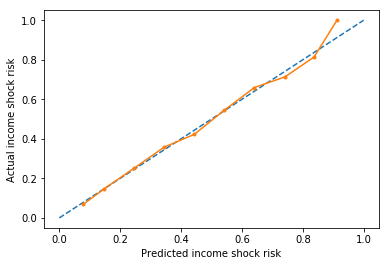

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data["shock"], test_size = 0.2)

final_model = GradientBoostingClassifier(n_estimators=100, learning_rate=.3, max_features=30, max_depth=4, min_samples_leaf=75)
final_model.fit(X_train, y_train)

y_predictions = final_model.predict_proba(X_test)[:,1]

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
logreg_x, logreg_y = calibration_curve(y_test, y_predictions, n_bins=10)

# Plot a reference line showing what a perfectly calibrated model would look like.
plt.plot([0, 1], [0, 1], linestyle='--')

# Plot the model's actual reliability.
plt.plot(logreg_y, logreg_x, marker='.')

plt.ylabel('Actual income shock risk')
plt.xlabel('Predicted income shock risk')
plt.show()

And let's plot a histogram of its outputs to understand how effectively it's differentiating between individuals of high and low income shock risk.

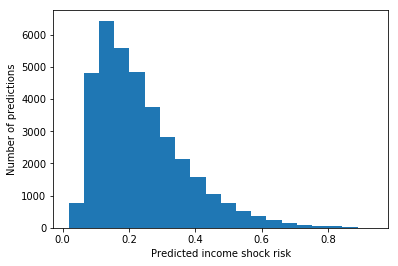

In [5]:
plt.hist(y_predictions, bins=20)
plt.ylabel('Number of predictions');
plt.xlabel('Predicted income shock risk')
plt.show()

Finally, to gain an understanding of how effectively the model can predict income shock risk on out-of-sample data, let's train a model on data from the 1979 cohort and test it on data from the 1997 cohort.

In [6]:
model_79 = GradientBoostingClassifier(n_estimators=100, learning_rate=.3, max_features=30, max_depth=4, min_samples_leaf=75)
model_79.fit(cohort_79[predictors], cohort_79["shock"])

predictions_97 = model_79.predict_proba(cohort_97[predictors])[:,1]

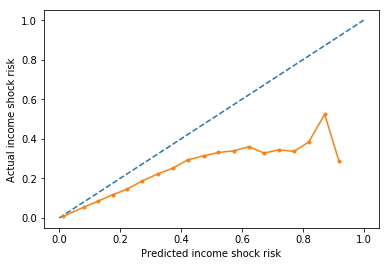

In [7]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
logreg_x, logreg_y = calibration_curve(cohort_97["shock"], predictions_97, n_bins=20)

# Plot a reference line showing what a perfectly calibrated model would look like.
plt.plot([0, 1], [0, 1], linestyle='--')

# Plot the model's actual reliability.
plt.plot(logreg_y, logreg_x, marker='.')

plt.ylabel('Actual income shock risk')
plt.xlabel('Predicted income shock risk')
plt.show()

Not bad! The model does a pretty decently calibrated job of predicting income shock risk up to about 50% predicted risk. Its calibration falls off substantially from there, but the good news is that only a small minority of instances have predicted risk that high:

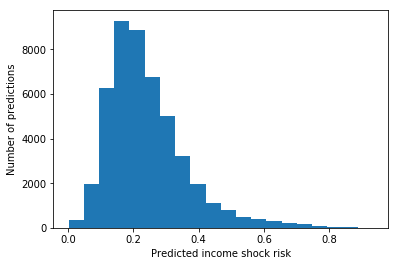

In [8]:
plt.hist(predictions_97, bins=20)
plt.ylabel('Number of predictions');
plt.xlabel('Predicted income shock risk')
plt.show()

Further, although the model's prediction of _absolute_ risk is poor on the right tail, it at least captures the high _relative_ risk these people face.

Finally, let's retrain our final model on all of our data, pickle it, and save our sample predictions for future use.

In [10]:
import pickle

final_model = GradientBoostingClassifier(n_estimators=100, learning_rate=.3, max_features=30, max_depth=4, min_samples_leaf=75)
final_model.fit(X, y)
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

df_test = pd.DataFrame(X_test).copy()
df_test['probability of income shock'] = y_predictions
df_test['shock'] = y_test
df_test.to_csv("sample_predictions.csv")